In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from itertools import permutations, accumulate
import time
import operator
import math

%matplotlib inline

# https://medium.com/deep-learning-hk/compute-document-similarity-using-autoencoder-with-triplet-loss-eb7eb132eb38
# https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
# FaceNet: https://arxiv.org/pdf/1503.03832.pdf

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def dfCheck(df):
    
    # Any column is > 20% null values
    if any(cnt / len(df) > 0.2 for cnt in df.isna().sum()):
        return False
    
    return True

In [4]:
tables = defaultdict(list)
path = "../Data/tables_025.csv"
maxRowLen = 0
maxRowLenR = ""
maxRowLenT = ""
allRows = []

with open(path, "r") as f:
    tableCount = 0
    for line in f:
        if line.startswith("List of"):
            tableCount += 1
            
tableFrac = 0.25
tablesLim = int(tableCount * tableFrac)
tablesRead = 0

print("Reading " + str(tablesLim) + " tables")

with open(path, "r") as f:
    reader = csv.reader(f)
    tableTitle = ""
    table = []
    
    for row in reader:
        if len(row) == 1 and row[0].startswith("List of"):
            if tableTitle: # Ignore first table, doesn't exist yet
                if dfCheck(pd.DataFrame(table)):
                    joinedRows = ['|||'.join(row) for row in table]
                    tables[tableTitle].append(joinedRows)
                    allRows.extend(joinedRows)
                table = []
            tableTitle = row[0]
            
            tablesRead += 1
            if tablesRead > tablesLim:
                break
            
        elif len(row) != 0:
            table.append(row)
            
            
print("Total tables analyzed: " + str(sum(len(val) for val in tables.values())))
maxRowLen = max(len(row) for row in allRows)
print("Maximum row length: " + str(maxRowLen))

Reading 41575 tables
Total tables analyzed: 39393
Maximum row length: 1017


In [5]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(allRows)
id_count = len(tokenizer.word_index)

In [6]:
"""
Convert each string into a list of its characters, converted to ints
Filter out rows which are too long (i.e. not many other rows at that length)
"""
import json

table_chars = []
sizes = [len(seq) for seq in allRows]
mu, sigma = np.mean(sizes), np.std(sizes)
maxRowLen = int(mu)

for i, category in enumerate(tables):
    for i, table in enumerate(tables[category]):
        tokens = tokenizer.texts_to_sequences(table)
        char_table = np.array([np.pad(seq, (0, maxRowLen - len(seq))) for seq in tokens if len(seq) <= maxRowLen])

        if len(char_table) >= 10:  # Remove tables that no longer have sufficient rows. We use 10 to allow for training & testing purposes   
            table_chars.append(char_table)

table_tensors = [torch.tensor(table) for table in table_chars]
print("Total # of tables in dataset: " + str(len(table_tensors)))

Total # of tables in dataset: 15762


In [7]:
# with open("../Data/tables.json", "w") as f:
#     f.write(json.dumps([l.tolist() for l in table_chars]))

In [39]:
"""
Model based on https://towardsdatascience.com/a-friendly-introduction-to-siamese-networks-85ab17522942
"""

class TripletModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, emb_dim, h_activ=nn.ReLU()):
        super().__init__()
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(maxRowLen, 128),
            nn.Sigmoid(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 128),
            nn.Sigmoid(),
            nn.Dropout(p=0.5),
            nn.Linear(128, emb_dim)
          )

    def forward(self, x):
        return self.fc1(x)

class TransformerModel(nn.Module):
    def __init__(self, ntoken, d_model, nhead, d_hid, nlayers, dropout = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = src.T
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = torch.sum(output, axis=0)
        return output

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout = 0.1, max_len = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


def generate_square_subsequent_mask(sz):
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1).to(device)

In [78]:
from sklearn.metrics import average_precision_score

class TableDataset(torch.utils.data.Dataset):
    def __init__(self, tables):
        self.sizes = torch.tensor([table.shape[0] for table in tables])
        self.table_positions = self.get_table_positions()
        self.rows = torch.cat(tables, 0)
        self.max = torch.max(self.rows)
        self.rows = self.rows / self.max  # Normalization

    def __len__(self):
        return len(self.sizes)

    def __getitem__(self, idx):
        if idx == 0:
            return self.rows[:self.sizes[0]]
            
        return self.rows[self.sizes[idx-1]:self.sizes[idx]]

    def get_table_positions(self):
        return np.array([0] + list(accumulate(self.sizes, operator.add)), dtype=np.int32)

    def shuffle(self):
        idxs = np.random.permutation(len(self.sizes))
        tables = torch.split(self.rows, list(self.sizes))  # split_size_or_sections needs a list for some reason
        tables = [tables[idx] for idx in idxs]
        self.rows = torch.cat(tables, 0)
        self.sizes = self.sizes[idxs]
        self.table_positions = self.get_table_positions()
        return

    def get_triplets(self, model, start_idx, batch_size, rows_per_table=3):
        """
        Using an online novel triplet mining strategy described in https://arxiv.org/pdf/1503.03832.pdf
        
        We perform all computations in numpy since it is much faster than with pytorch
        """
        # t = time.time()
        table_positions = self.table_positions[start_idx: start_idx+batch_size+1]

        # Get 5 rows per table for a subset of the tables
        size = (rows_per_table, min(batch_size+1, table_positions.shape[0]) - 1)
        chosen_row_idxs = np.random.randint(table_positions[:-1], table_positions[1:], size=size).T.flatten()
        chosen_rows = self.rows[chosen_row_idxs].long()

        anchor_idxs = np.arange(chosen_rows.shape[0])
        positive_idxs = np.array([])
        negative_idxs = np.array([])

        mask = np.ones(chosen_rows.shape[0], dtype=bool)

        # turn off autograd to speed up computation
        with torch.no_grad():
            embeddings = np.array(model(chosen_rows.to(device)).cpu())
    
        dists = np.matmul(embeddings, embeddings.T)

        pos_mask = np.zeros(dists.shape, dtype=bool)
        for i in range(0, embeddings.shape[0], rows_per_table):
            pos_mask[i:i+rows_per_table,i:i+rows_per_table] = 1

        neg_mask = ~pos_mask

        # Ensure the same rows are not comapred against each other
        # np.fill_diagonal(pos_mask,0)
        positive_dists = np.where(pos_mask, dists, 0)
        negative_dists = np.where(neg_mask, dists, 0)

        positive_idxs = np.argmax(positive_dists, axis=1)
        negative_idxs = np.argmin(negative_dists, axis=1)
        
        # print("Elapsed: " + str(time.time() - t), len(chosen_rows), len(anchor_idxs))
        return (
            chosen_rows.to(device), 
            torch.tensor(anchor_idxs).long().to(device), 
            torch.tensor(positive_idxs).long().to(device), 
            torch.tensor(negative_idxs).long().to(device)
        )

    def get_average_precision(self, model, first_tables=20):
        with torch.no_grad():
            embs = np.array(model(self.rows.long().to(device)).cpu())  # Our model uses small => better, avg_precision uses opposite
        precs = []

        dists = np.matmul(embs, embs.T)
        pos_mask = np.zeros(dists.shape, dtype=bool)
        
        for table_start, table_end in zip(self.table_positions[:first_tables], self.table_positions[1:first_tables]):
            pos_mask[table_start:table_end,table_start:table_end] = 1

        for mask, scores in zip(pos_mask, dists):
            # print(mask, scores)
            avg_prec_score = average_precision_score(mask, scores)
            precs.append(avg_prec_score)

        return precs

table_tensors_train = []
table_tensors_val = []
table_tensors_test = []
take_tables = 2
torch.manual_seed(42)

# Generate training, validation, and testing datasets
for table in table_tensors[:take_tables]:
    # Select 5 random rows to be validation / test rows
    non_train_idxs = torch.randint(0, table.shape[0], size=(1, 5)).flatten()
    val_idxs, test_idxs = non_train_idxs[:3], non_train_idxs[3:]

    # All other rows are training rows
    train_idxs = torch.ones(table.shape[0], dtype=bool)
    train_idxs[non_train_idxs] = False

    # append the data to appropriate list
    table_tensors_train.append(table[train_idxs])
    table_tensors_val.append(table[val_idxs])
    table_tensors_test.append(table[test_idxs])

dataset_train = TableDataset(table_tensors_train)
dataset_val = TableDataset(table_tensors_val)
dataset_test = TableDataset(table_tensors_test)

In [79]:
src_mask = generate_square_subsequent_mask(maxRowLen)
batch, anchors, positives, negatives = dataset_val.get_triplets(model, 0, 2)

In [83]:
def train(model, optimizer, loss_fn, data, BATCH_SIZE=2):
    model.train()
    losses = []

    for i in range(0, len(data), BATCH_SIZE):
        batch, anchors, positives, negatives = data.get_triplets(model, i, BATCH_SIZE)
        optimizer.zero_grad()
        anchor_embs = model(batch[anchors])
        positive_embs = model(batch[positives])
        negative_embs = model(batch[negatives])
            
        loss = loss_fn(anchor_embs, positive_embs, negative_embs)
        
        loss.backward() # back-propagation, could do manually
        optimizer.step() # Adjusts the weights for us
        losses.append(loss.item())

    return losses

def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        precision_scores = data.get_average_precision(model)

    return precision_scores

ntokens = id_count + 1  # size of vocabulary
emsize = 200  # embedding dimension
d_hid = 200  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # number of heads in nn.MultiheadAttention
dropout = 0.2  # dropout probability
EPOCHS = 10000
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
loss_fn = nn.TripletMarginLoss(1, 2).to(device)
optimizer = optim.SGD(model.parameters(), lr = 1e-3, weight_decay=0.0005)
train_losses = []
precision_scores = []

for epoch in range(EPOCHS):
    # print("EPOCH: " + str(epoch))

    dataset_train.shuffle()
    train_losses += train(model, optimizer, loss_fn, dataset_train)

    if epoch % 100 == 0:
        # dataset_val.shuffle()
        prec = evaluate(model, dataset_val)
        precision_scores.extend(prec)
        print("Average Precision at epoch %s: %s" % (epoch, np.mean(prec)))

Average Precision at epoch 0: 0.6055555555555555
Average Precision at epoch 100: 0.6055555555555555
Average Precision at epoch 200: 0.487037037037037
Average Precision at epoch 300: 0.5166666666666667
Average Precision at epoch 400: 0.6055555555555555
Average Precision at epoch 500: 0.6055555555555555
Average Precision at epoch 600: 0.487037037037037
Average Precision at epoch 700: 0.487037037037037
Average Precision at epoch 800: 0.6055555555555555
Average Precision at epoch 900: 0.487037037037037
Average Precision at epoch 1000: 0.6055555555555555
Average Precision at epoch 1100: 0.6055555555555555
Average Precision at epoch 1200: 0.487037037037037
Average Precision at epoch 1300: 0.6055555555555555
Average Precision at epoch 1400: 0.5166666666666667
Average Precision at epoch 1500: 0.487037037037037
Average Precision at epoch 1600: 0.5166666666666667
Average Precision at epoch 1700: 0.487037037037037
Average Precision at epoch 1800: 0.487037037037037
Average Precision at epoch 1900:

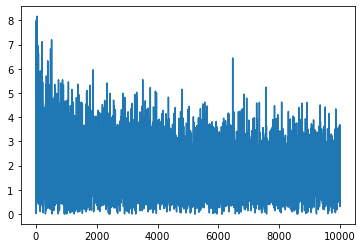

In [84]:
plt.plot(train_losses)

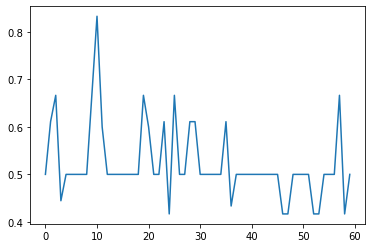

In [ ]:
plt.plot(precision_scores)

In [82]:
with torch.no_grad():
    batch, anchors, positives, negatives = dataset_train.get_triplets(model, 0, 2)
    positive_embs = model(batch[positives]) 
    negative_embs = model(batch[negatives]) 
    anchor_embs = model(batch[anchors])

    print(anchor_embs)
    print(positive_embs)
    print(negative_embs)

    print(loss_fn(anchor_embs, positive_embs, negative_embs))

tensor([[-62.8419,  39.8016,  80.7338,  ...,  -7.5753, 108.8597, -80.1905],
        [-64.5987,  42.8025,  85.3388,  ...,  -6.4767, 103.6926, -82.6397],
        [-65.4186,  44.3794,  82.0520,  ...,  -5.9828, 110.5686, -84.1612],
        [-67.7970,  44.8762,  83.7106,  ...,  -5.7798, 113.0596, -86.0408],
        [-61.9913,  44.5986,  85.8799,  ...,  -6.1727, 106.8777, -83.6437],
        [-63.5410,  44.5264,  86.0984,  ...,  -4.6227, 112.9923, -84.2130]],
       device='cuda:0')
tensor([[-69.3643,  44.7305,  86.9587,  ...,  -6.7774, 111.6379, -77.0954],
        [-64.3062,  44.9177,  86.6477,  ...,  -7.6228, 102.0001, -82.2597],
        [-64.7123,  42.2519,  82.8041,  ...,  -3.3238, 111.3392, -89.5604],
        [-62.6974,  43.3751,  85.0456,  ...,  -5.7928, 115.2749, -81.9084],
        [-69.6486,  43.2332,  84.9230,  ..., -11.6431, 104.2225, -79.3309],
        [-64.9196,  43.1676,  86.7087,  ...,  -4.9971, 102.2482, -83.0609]],
       device='cuda:0')
tensor([[-61.9141,  44.5090,  86.4286,

In [ ]:
for x, y in model.named_parameters():
    print(x, y)

fc1.0.weight Parameter containing:
tensor([[ 0.0598,  0.0683,  0.0481,  ..., -0.0751,  0.0030, -0.0806],
        [-0.0280,  0.0521,  0.0593,  ..., -0.0045,  0.0641,  0.0511],
        [ 0.0378,  0.0125,  0.0244,  ..., -0.0393,  0.0073,  0.0021],
        ...,
        [-0.0146, -0.0776, -0.0010,  ...,  0.0701,  0.0474, -0.0784],
        [ 0.0889,  0.0721, -0.0528,  ...,  0.0137,  0.0360,  0.0532],
        [ 0.0141, -0.0414,  0.0252,  ..., -0.0462, -0.0711, -0.0621]],
       requires_grad=True)
fc1.0.bias Parameter containing:
tensor([ 1.1631e-03, -1.5671e-02,  4.2719e-02, -1.9671e-02, -6.1954e-02,
         6.9833e-02,  2.1540e-02, -8.8451e-02,  1.9791e-02,  9.5775e-03,
         4.4858e-02, -5.1670e-02,  5.3314e-03, -7.9615e-02,  1.5851e-02,
         6.1985e-02, -3.0717e-02, -1.6099e-03, -8.3902e-02,  4.0252e-02,
        -3.2124e-02,  3.7077e-02, -8.6877e-02,  1.3426e-02, -6.0268e-02,
        -8.3155e-02, -4.3461e-02,  4.7141e-02,  6.0672e-02, -6.7554e-03,
         7.8005e-02,  3.7435e-02,

In [ ]:
with torch.no_grad():
  print(model.forward_once(dataset_val.rows[:5]))

tensor([[-1.4705e-06, -1.5091e-06,  2.6124e-06,  1.1937e-06, -9.5364e-07,
          4.8526e-09,  2.9668e-06,  2.0681e-06,  3.0560e-06, -8.6873e-07,
          2.4488e-06, -2.7257e-06, -2.9203e-06, -2.5097e-06,  2.0711e-06,
         -1.0097e-06, -3.0860e-06,  2.6070e-06, -1.7544e-06, -2.1002e-06,
          2.0549e-06, -1.7169e-06, -8.0820e-07, -2.8750e-06,  1.7985e-06,
          1.3931e-06,  1.1287e-06, -2.0333e-06,  1.6162e-06, -1.7779e-06,
         -2.3550e-06, -1.8789e-06],
        [-1.4705e-06, -1.5091e-06,  2.6124e-06,  1.1937e-06, -9.5364e-07,
          4.8526e-09,  2.9668e-06,  2.0681e-06,  3.0560e-06, -8.6873e-07,
          2.4488e-06, -2.7257e-06, -2.9203e-06, -2.5097e-06,  2.0711e-06,
         -1.0097e-06, -3.0860e-06,  2.6070e-06, -1.7544e-06, -2.1002e-06,
          2.0549e-06, -1.7169e-06, -8.0820e-07, -2.8750e-06,  1.7985e-06,
          1.3931e-06,  1.1287e-06, -2.0333e-06,  1.6162e-06, -1.7779e-06,
         -2.3550e-06, -1.8789e-06],
        [-1.4705e-06, -1.5091e-06,  2.61